In [ ]:
# load libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_datareader.data as web
# define functions  
def get_daily_wrds(conn,tickers=None):
  
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    
    query = f"""
        SELECT permno, date, ret, retx, prc       
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date,permno
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
# Pivot data to have dates as index and tickers as columns
    daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')    
    daily_returns=daily_returns[tickers]

    return daily_returns


def get_factors(factors='CAPM'):   
    if factors=='CAPM':
        fama_french = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
        daily_data.index = pd.to_datetime(daily_data.index)
        df_factor = daily_data[['RF','Mkt-RF']] 
    elif factors=='FF3':
        fama_french = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
        daily_data.index = pd.to_datetime(daily_data.index)
        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':
        fama_french = web.DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
        daily_data.index = pd.to_datetime(daily_data.index)
        df_factor = daily_data[['RF','Mkt-RF','SMB','HML','RMW','CMA']]
    else:
        fama_french = web.DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
        daily_data.index = pd.to_datetime(daily_data.index)
        df_factor = daily_data[['RF','Mkt-RF','SMB','HML','RMW','CMA']]
        fama_french = web.DataReader("F-F_Momentum_Factor_daily", "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')    

    return df_factor/100

# Estimation: From historical data to the future dynamics of returns

We have been working with a single asset, since factor model

Realized returns:

$$r=rf+\alpha + b(f-rf)+\epsilon$$

Expected  returns

$$E[r]=rf+\alpha + b*E[f]$$


Expected excess returns

$$E[r^{e}]=\alpha + b*E[f]$$

Variance:


$$Var(r)=b^2Var(f-rf)+Var(\epsilon)$$


To know the expected returns of your investment you need
1. The risk-free rate
2. The beta 
3. The factor risk-premia
4. The asset specific alpha

To know the risk/variance of your investment you need

5. The factor variance
6. The asset specific variance
 

## What do we need to know to invest?

Do you want to know how this stock behaved in the past?

Do we want to know how it behaved in the recent past?

When should we care about historical data?



We need to know these parameters for our investment period, say next month or next year

Some of those we observe directly in financial markets like the risk-free rate--financial markets tell you exactly how much your will ear goign forward

others we need to use some data to form our views

I will discuss each one by one

## Betas 

Factors models are all about the time-series co-movement between assets and some common factors. For now we are focused on single factors models, but we will soon be thinking about multiple-factors at the same time.

For now we will focus on factors that can be expressed in excess returns, like the returns on the market portfolio. Practicioners often use characteristics as direct proxys for beta--we will see that later. This is useful when we have many factors...but does not work to the most important factor of all--the market factor.

Fundamentally any risk-factor can be represented in terms of a return of a specific portfolio.

The beta that we are interested is the forward-looking degree of co-movement between the asset and the factor

Specifically it is

$$\beta_t=\frac{Cov_t(r_{t+1}^{e},f_{t+1})}{var_t(f_{t+1})}$$


- What this notation means?
- It is asking to what extent the asset returns are above it's expected values when the factor is above it's expected value
- It normalizes everything by the variance of the factor
- So a beta of 1 means that the asset is EXPECTED to move 1 for 1 with the factor
- But of course it can have some additional idio risk on top
- The subscripts in the covariance and variance means that it is these moments from the perspective of someone that has all the informationup to  date $t$
- That is, you don't know the particular realization of the variables


How do we estimate betas?

We run a regression!

 We typically do not use the whole sample when using individual stocks--stocks behavior change. So we want the most up to date behavior--but cannot be too short otherwise you cannot say anything as estimation uncertainty will be very high!
 
Academic literature likes to use between 1 year to 2 years if using daily data

(when working with illiquid stocks daily data might be problematic and weekly or monthly might be more advisable, but the sample period will have to be increased. For example, for monthly people use 5 years)

We will focus on simple regressions, and briefly discuss alternatives



In [ ]:
%pip install wrds
import wrds

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
[12060]


c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)


<Axes: >

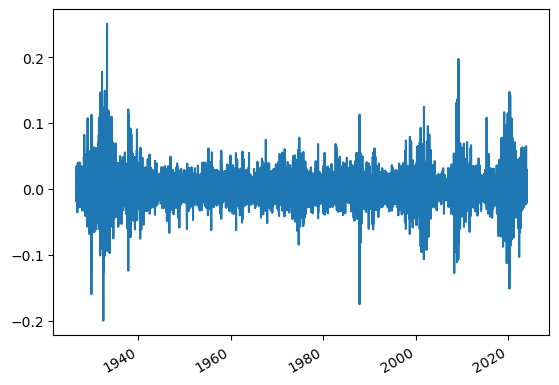

In [61]:
conn = wrds.Connection()
ticker='GE'
df_returns = get_daily_wrds(conn,[ticker])
df_factor = get_factors()
df_return, df_factor = df_returns.align(df_factor, join='inner', axis=0)

df_eret=df_return[ticker]-df_factor['RF']
df_eret.plot()

In [62]:

import statsmodels.api as sm

X = df_factor['Mkt-RF']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df_eret
model = sm.OLS(y, X).fit(dropna=True)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                 3.124e+04
Date:                Sat, 14 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:39:22   Log-Likelihood:                 76954.
No. Observations:               25646   AIC:                        -1.539e+05
Df Residuals:                   25644   BIC:                        -1.539e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.323e-05   7.52e-05      0.176      0.8

Lets focus on the beta

1. What frequency is it? Do we need to multiply to make it yearly?

$$\beta=\frac{Cov(r,f)}{Var(f)}$$

2. How well estimated?

3. How confident we are that the beta is less  than 1?

4. How much uncertainty do we have about it?

5. Say, what is the 95% confidence interval?

In [63]:
model.bse



const     0.000075
Mkt-RF    0.006956
dtype: float64

In [64]:
from scipy.stats import norm
x=(1-0.95)/2
[model.params['Mkt-RF'] +norm.ppf(x)*model.bse['Mkt-RF'],model.params['Mkt-RF'] -norm.ppf(x)*model.bse['Mkt-RF']]


[1.2158455647969004, 1.2431118925672446]

barely any uncertainty and we are quite sure it is above 1. 

How sure?

Note that the null in the table is for the null hypothesis that beta=0

$$t=\frac{\beta-1}{se(\beta)}$$


In [65]:
tstat=(model.params['Mkt-RF'] -1)/model.bse['Mkt-RF']
tstat

32.99087777592763

What is the probability that beta is lower than 1?

$$Prob(z>tstat)=1-Prob(z<tstat)=1-F(tstat)$$

In [66]:
1-norm.cdf(t_test1)

0.0

But is beta really constant?

Should we be using such a long sample?

Lets look at at 2 year periods

<Axes: >

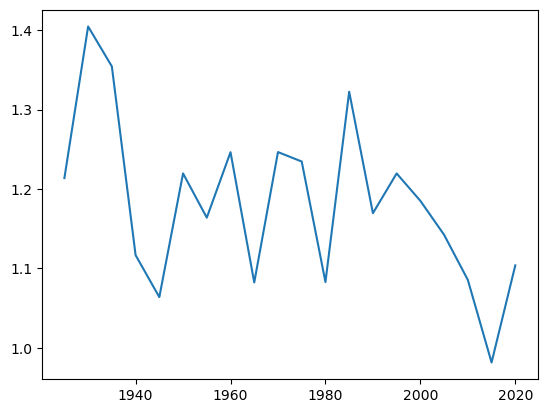

In [71]:
df=df_factor
df['re']=df_eret

df.groupby((df.index.year // 2) * 2).apply(lambda x: sm.OLS(x['re'], sm.add_constant(x['Mkt-RF'])).fit().params['Mkt-RF']).plot()

Almost always above 1, but all over the place

are the betas really changing like that or is that smaple uncertainty?



<Axes: >

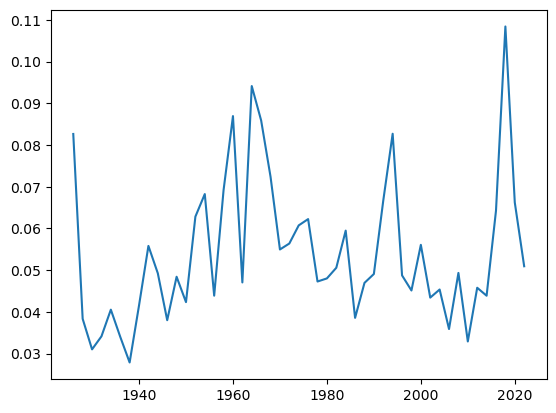

In [72]:
df.groupby((df.index.year // 2) * 2).apply(lambda x: sm.OLS(x['re'], sm.add_constant(x['Mkt-RF'])).fit().bse['Mkt-RF']).plot()

Standard errors are much larger now!

It increase many fold--of course--the sample is much shorter

- Look at different sampling (30,5,2,1)

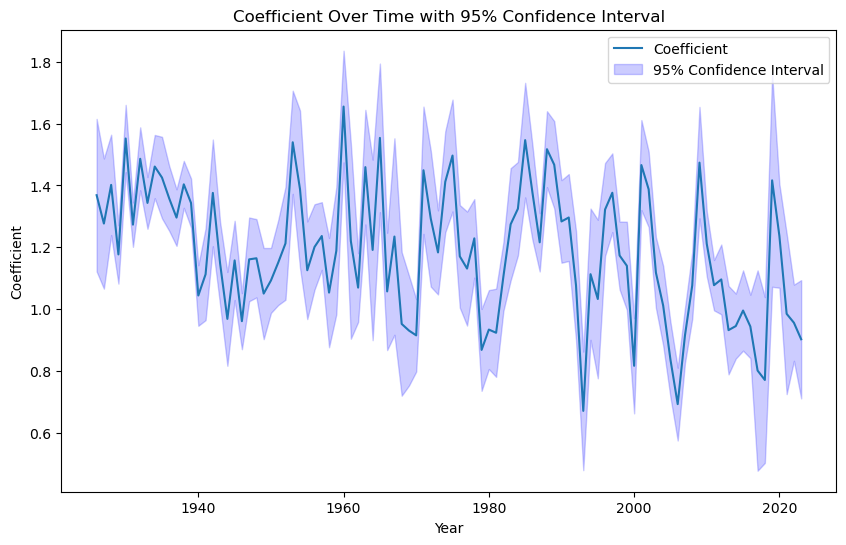

In [102]:
y=1
a=df.groupby((df.index.year // y) * y).apply(lambda x: sm.OLS(x['re'], sm.add_constant(x['Mkt-RF'])).fit().bse['Mkt-RF'])
b=df.groupby((df.index.year // y) * y).apply(lambda x: sm.OLS(x['re'], sm.add_constant(x['Mkt-RF'])).fit().params['Mkt-RF'])
plt.figure(figsize=(10, 6))
plt.plot(b.index, b, label='Coefficient')
plt.fill_between(b.index, b - 1.96 * a, b + 1.96 * a, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Coefficient Over Time with 95% Confidence Interval')
plt.legend()
plt.show()


Sometimes standard errors can be deceiving

Our estimation is super confident of the beta on a particular year, but we need to know the beta NEXT year

b

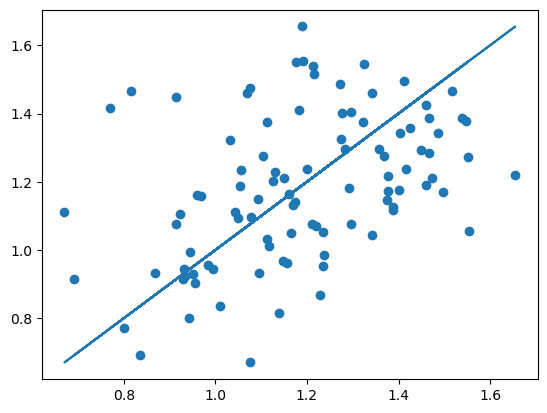

In [103]:
plt.scatter(b.shift(1), b)
plt.plot(b.shift(1), b.shift(1),'-')

There is a relationship but much more variability then the standard errors suggest

In [104]:
sm.OLS(b[1:], sm.add_constant(b.shift(1)[1:])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     19.36
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           2.83e-05
Time:                        00:08:26   Log-Likelihood:                 20.745
No. Observations:                  97   AIC:                            -37.49
Df Residuals:                      95   BIC:                            -32.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6919      0.113      6.096      0.000       0.467       0.917
0              0.4137      0.094      4.400      0.000       0.227       0.600
==============================================================================
Omnibus:                        2.395   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                2.408
Skew:                           0.359   Prob(JB):                        0.300
Kurtosis:                       2.717   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

How do we interpret these coefficients?

People in the industry also like exponential decay models

Text(0.5, 1.0, 'Weights Over Time')

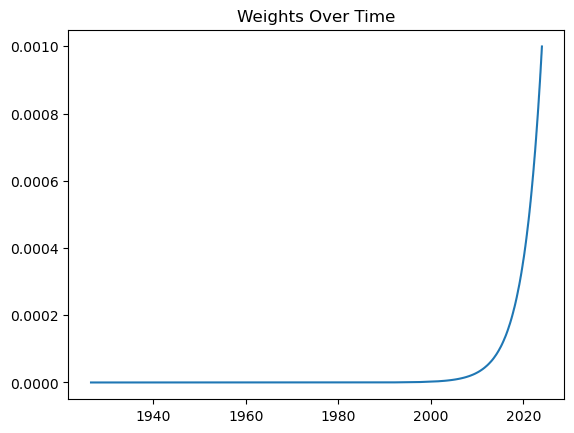

In [151]:
X = df['Mkt-RF']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df['re']
n=y.shape[0]
decay_rate = 0.001 # Lambda controls the decay rate

df['weights']= y*0+np.exp(-decay_rate * np.arange(n)[::-1])  # Reverse order for recent weights
df['weights'] /= df['weights'].sum()  # Normalize weights to sum to 1 (optional)

plt.plot(df['weights'])
plt.title('Weights Over Time')

In [132]:
model = sm.WLS(y, X, weights=df['weights'])
results = model.fit()

# Display results
print("Regression Summary:")
print(results.summary())


Regression Summary:
                            WLS Regression Results                            
Dep. Variable:                     re   R-squared:                       0.344
Model:                            WLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                 1.346e+04
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:25:21   Log-Likelihood:                -56194.
No. Observations:               25646   AIC:                         1.124e+05
Df Residuals:                   25644   BIC:                         1.124e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000

## Variances

Variances come in two flavors. Factor variance and idiosyncratic variance. 

Both tend to move together at high frequencies (days, weeks, a few months)

At horizons longer than 1 year, you are better off with low frequency estimates of variances--say use a two year-five year sample of daily returns

Fro investment horizons shorten than a month you certainly need to pay attention to higher frequency variation. So you might estimate using 3-month, 1-month , and even one day of data using minute-by-minute data

Lets start with the factor variance, that is the variance of the market

- For intuition I will  annualize it. Always look at these moments at yearly frequency so you develop intuition about what to expect and quickly detect if something is wrong
- Because our data is daily, this means multiplying by the number of days in a year
- I will also be taking the square-root and look at standard deviation instead of variance

$$Standard~deviation=\sqrt{Variance}$$ 

In [153]:
(df['Mkt-RF'].var()*252)**0.5

0.17158032498498688

Volatility is 17% in a year

Does it move around? Look at 5 years, yearly, monthly

<Axes: >

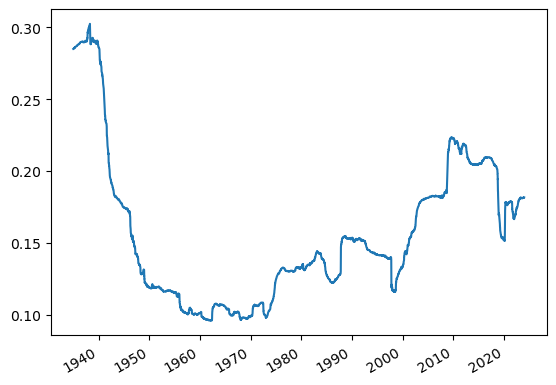

In [158]:
freq=252*10
(df['Mkt-RF'].rolling(window=freq).std()*252**0.5).plot()

What do you notice?

Clearly the REALIZED VOLATILITY, just like the REALIZED RETURN, moves around a lot

Does that mean that actual forward looking volatility moves around?

How would we evaluate?

Look at monthly, yearly, 5 years

<Axes: >

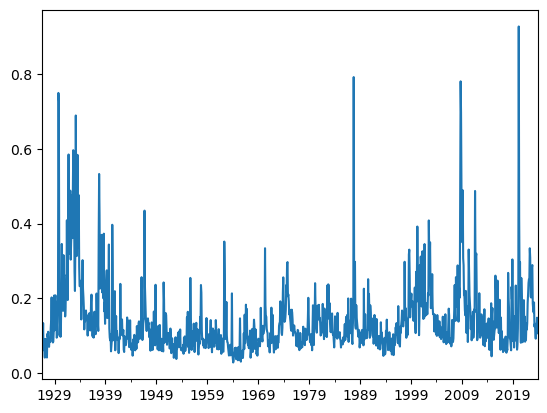

In [168]:

df_var=df.groupby(df.index+pd.offsets.MonthEnd(0)).apply(lambda x:x['Mkt-RF'].var()*252)

(df_var**0.5).plot()

You should see a lot of clustering which suggests you can forecast using past values of variance


In [169]:
import statsmodels.api as sm

# Create the lagged variable
df_var_lag = df_var.shift(1)

# Drop the first row with NaN value
df_var = df_var[1:]
df_var_lag = df_var_lag[1:]

# Define the independent variable (lagged variance) and add a constant term
X = sm.add_constant(df_var_lag)

# Define the dependent variable (current variance)
y = df_var

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     477.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           4.68e-89
Time:                        08:58:31   Log-Likelihood:                 1844.6
No. Observations:                1169   AIC:                            -3685.
Df Residuals:                    1167   BIC:                            -3675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0133      0.002      8.185      0.0

- you see we can forecast quite a bit of variation even with a only using the last month variance
- Can do better using multiple frequencies
  

Lets look now at the idiosyncratic component

Recall that


$$\epsilon=r^e-(\alpha+\beta*f)$$

and 

$$Var(\epsilon)=Var(r^e-\beta*f)$$

So the variance of the idio component very much depends on your estimate of beta.

Industry models will make them consistent with each other

Here we will fix our beta estimate for the whole sample and then look at variation in the volatility of residuals the same we did for the variance of the market

<Axes: >

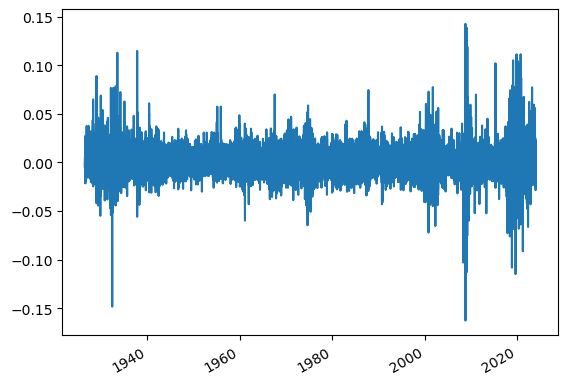

In [ ]:
df=df.dropna()
X = df['Mkt-RF']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df['re']
model = sm.OLS(y, X).fit(dropna=True)
df['e']=model.resid
df['e'].plot()

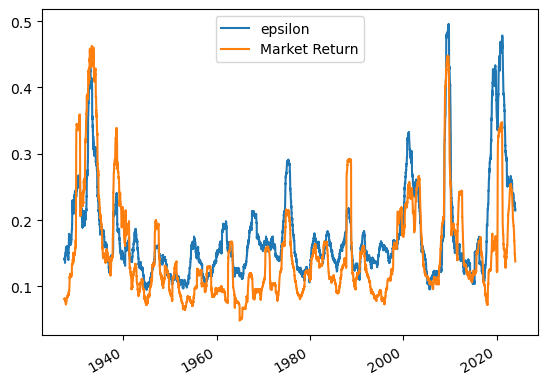

In [189]:
(df['e'].rolling(window=252).std()*252**0.5).plot()
(df['Mkt-RF'].rolling(window=252).std()*252**0.5).plot()
plt.legend(['epsilon','Market Return'])

<Axes: >

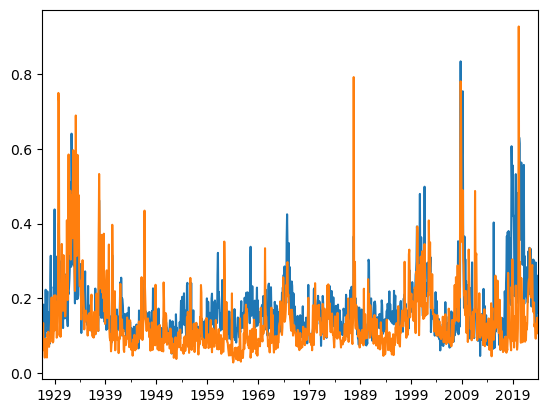

In [190]:

((df.groupby(df.index+pd.offsets.MonthEnd(0))['e'].var()*252)**0.5).plot()
((df.groupby(df.index+pd.offsets.MonthEnd(0))['Mkt-RF'].var()*252)**0.5).plot()

You see a very similar picture

### Cross-Section vs Time-series 

- Variances tend to move up and down together
- you can repeat the forecasting exercise we did for the market variance to check out degree of  variation
- One thing that will be really important is to be able to detect variation in these moments across stocks
- Here we are exploring the extent we can detect variation over time, but lots of trading strategies will be about comparing different stocks and be able to tell which one is more volatile going forward
- By and large the answer for both beta and variance is that we can using reasonable lookback windows
- Typically two years is a good window  , but lots of fine tuning around it



## Factor Risk-Premia


- While conceptually both alpha and risk premia are both expected excess returns, in practice our approach is very different

- Factor risk-premia likely move around, but we think of then as more stable features of the economic environment

- They are compensation for systematic risk, so they don't go away just because investors are aware of it 

  - Specially true for risk-premia on the market factor

- We are more comfortable in using long data sets to measure it

  

We will now look at the risk-premia on the market and discuss how to think about the estimation, how to think about the precision of these estimates and briefly discuss how it might move around over time

### 1. If We think a risk-premia does not move too much over time, then our best estimate is sample average 


$$\hat{E}[r^e]=\frac{1}{T}\sum_{t=1}^T r^e_t$$ 

The standard errors associated with these estimates is 


$$se(\hat{E}[r^e])=\sqrt{\frac{Var(r^e_t)}{T}}$$ 

- The longer the sample, the higher our precision, the lower the standard errors
- The higher the asset variance, the higher our standard errors, the lower our precision





In [203]:
# Calculate the average for the market
market_average = df['Mkt-RF'].mean()
market_std_dev = df['Mkt-RF'].std()
#number of observations
T=(len(df['Mkt-RF'])
# Calculate the standard error of the average
market_average_std_error = market_std_dev /T ** 0.5)

print(f"Market standard deviation: {market_std_dev}")
print(f"Market Average: {market_average}")
print(f"Standard Error of the Average: {market_average_std_error}")

print(f"t-stat relative to zero null: {(market_average-0)/market_average_std_error}")

Standard Error of the Average: 0.010808544518617085
Market Average: 0.0003018248459798799
Standard Error of the Average: 6.749279240098983e-05
t-stat relative to zero null: 4.471956711861479


This is daily so it looks really ugly. Lets look at annual terms

- The mean is multiplied by 252, because there are 252 days in a year
- Variance is also multiplied by 252, so standard-deviaiton gets multiplied by square root
- The number of observations are divided by 252 because now things are in years

In [208]:
# Calculate the average for the market
market_average = (df['Mkt-RF']*252).mean()
market_std_dev = (df['Mkt-RF']).std()*252**0.5
T=((len(df['Mkt-RF'])/252)
# Calculate the standard error of the average
market_average_std_error = market_std_dev / T** 0.5)

print(f"Market standard deviation: {market_std_dev}")
# Calculate the standard error of the average


print(f"Market Average: {market_average}")
print(f"Standard Error of the Average: {market_average_std_error}")

print(f"t-stat relative to zero null: {(market_average-0)/market_average_std_error}")

Market standard deviation: 0.17158032498498688
Market Average: 0.07605986118692974
Standard Error of the Average: 0.017008183685049437
t-stat relative to zero null: 4.47195671186148


note that the t-stat is invariant to frequency transformation

This makes the important point that **sampling more frequently does not lead to more precise estimates of the expected return**

"only time will tell" could not be any truer for means: Both mean and variance are scaled up by the frequency. 

Long sample allow us to be very confident that the market risk-premium is positive on average

We can be fairly confident even that risk-premium is higher than 3%

In [199]:
nullh=0.03
print(f"t-stat relative to {nullh} null: {(market_average-nullh)/market_std_error}")

t-stat relative to 0.03 null: 2.708099938232526


Suppose risk-premium is time-varying but moves kind of slowly

Also lets suppose the variance is constant at the sample mean

How long a sample do I need to be 95% confident that the expected value is higher than the value "x"

I need t-stat


$$t-stat>F^{-1}(0.95)=1.64$$


$$t-stat=\frac{\hat{E}[r^e]-x}{se(\hat{E}[r^e])}>F^{-1}(0.95)=1.64$$


$$t-stat=\frac{\hat{E}[r^e]-x}{\sqrt{\frac{Var(r^e_t)}{T}}}>F^{-1}(0.95)=1.64$$

manipulating

$$\sqrt{T}\frac{\hat{E}[r^e]-x}{\sigma(r^e_t)}=1.64$$

$$T=1.64^2*\left(\frac{\hat{E}[r^e]-x}{\sigma(r^e_t)}\right)^{-2}$$



- The more confident you want to be, the longer the sample you need
- The more volatile the asset the longer the sample
- The higher the expected value you have for the asset, the shorten the sample
- in the case of x=0 this becomes

$$T=1.64^2*\left(\frac{\hat{E}[r^e]}{\sigma(r^e_t)}\right)^{-2}$$

- what is this term $\frac{\hat{E}[r^e]}{\sigma(r^e_t)}$ called?
  

  Suppose we have an asset with similar moments as the market, how long a sample do I expect to need to be confident that the asset has indeed positive mean?

In [214]:
quantile = 0.95
value_at_quantile = norm.ppf(quantile)
sr=market_average/market_std_dev
(sr)**(-2)*value_at_quantile**2


13.76824003316407

> What does it tell you about opening a hedge fund?

Lets look at the market spliting it in 15 year periods



<Axes: >

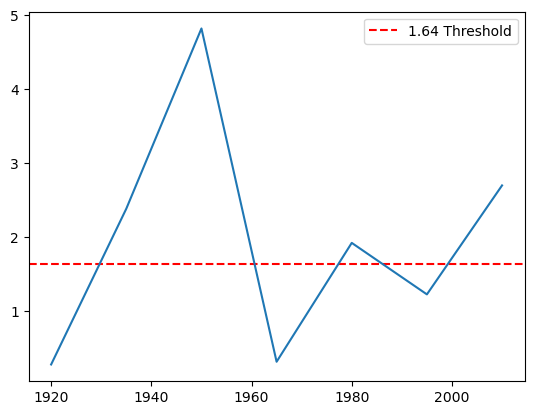

In [220]:
y=15
a=df.groupby((df.index.year // y) * y).apply(lambda x: x['Mkt-RF'].mean()/(x['Mkt-RF'].std()/x['Mkt-RF'].count()**0.5))
plt.axhline(y=1.64, color='r', linestyle='--', label='1.64 Threshold')
plt.legend()
a.plot()

- even then there would be multiple 15 year periods where we would not be 10% sure that the market has a positive expected value

- If you think the market risk-premium moves much faster than this, then the sample mean is fairly unreliable estimator

- This insight will be very important to think about alphas

- This also tells you that timing the market based on past performance--even 15 past performance is a disaster!

Huge literature tries to forecast market return

- They use past volatility (bad, does not work at all)
- Dividend yield (maybe, a bit unreliable)
- earnings yield (similar for dividend yield)
- "Variance-Risk Premium", basically the VIX minus past vol--that works a bit better, but sample is short, so hard to be sure

IT is very tricky business and even if your model is right, data can be off for a long time, so most funds don't try 

## Alpha is all you need

In one way estimating an alpha is similar to estimating factor risk-premia

- Both are expected values of the excess returns
- Alpha is the expected value of the hedged portfolio

$$\alpha=E[r^e-\beta f]$$

- So you might think the longer the sample, the better right?
- But while for factor premia we have lots of theory telling us that it should move very slowly--it is about aggregate risk--and it should not go away just because people know it
   * it is compensation for aggregate risk!!--people choose not to go all the way because it is risky!
- For alphas, it is the opposite, everyone is jumping when alpha is detected. The whole point is that alpha, real alpha, are premiums that you earn after you HEDGE out any aggregate factor exposure you portfolio have
- What happens with the price as more people buy an asset?
- What happens with the asset actual long-term value?
- What happens with the alpha?


So lets first get a few stocks and compare their alphas. I will focus on one sector

[10104, 10107, 14593, 76076, 90319]


c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)


ticker          MSFT      AAPL      CSCO      ORCL     GOOGL
2004-08-20  0.002900  0.002881 -0.011568 -0.010607  0.079434
2004-08-23  0.004362  0.009041  0.015840 -0.001020  0.010014
2004-08-24 -0.000050  0.027942 -0.010999  0.002863 -0.041458
2004-08-25  0.011330  0.034379  0.018400  0.006726  0.010725
2004-08-26 -0.004043  0.048664 -0.007814 -0.016396  0.017969


<Axes: >

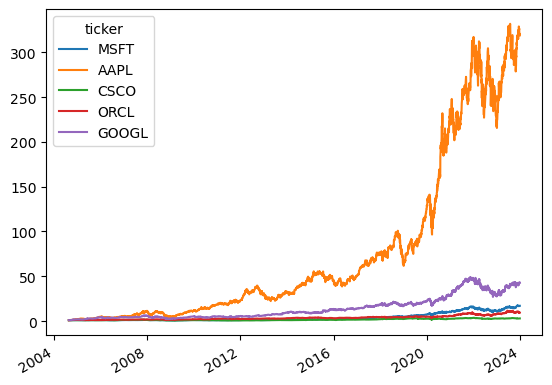

In [ ]:
# you probably need to load wrds again if you have been talking for a while :)
conn = wrds.Connection()
tickers=['MSFT','AAPL','CSCO','ORCL','GOOGL']
df_returns = get_daily_wrds(conn,tickers).dropna()

df_factor = get_factors()
df_return, df_factor = df_returns.align(df_factor, join='inner', axis=0)

df_re=df_return.subtract(df_factor['RF'],axis=0)

print(df_re.head())
(1+df_re).cumprod().plot()



In [264]:
import statsmodels.api as sm

# Define the period length
period_length = 1

# Create a dictionary to store the results
results_dict = {'Ticker': [], 'Period': [], 'Alpha': [], 'Alpha_SE': [], 'Alpha_Tstat': []}

# Loop through each 5-year period
for start_year in range(df_re.index.year.min(), df_re.index.year.max(), period_length):
    end_year = start_year + period_length - 1
    period_label = end_year
    
    # Filter the data for the current period
    period_mask = (df_re.index.year >= start_year) & (df_re.index.year <= end_year)
    df_re_period = df_re[period_mask]
    df_factor_period = df_factor[period_mask]
    
    # Loop through each column in df_re
    for ticker in df_re.columns:
        try:
            y = df_re_period[ticker]
            X = sm.add_constant(df_factor_period['Mkt-RF'])
            
            # Perform the regression
            model = sm.OLS(y, X, missing='drop').fit()
            
            # Store the results
            results_dict['Ticker'].append(ticker)
            results_dict['Period'].append(period_label)
            results_dict['Alpha'].append(model.params['const']*252)
            results_dict['Alpha_SE'].append(model.bse['const']*252)
            results_dict['Alpha_Tstat'].append(model.params['const']/model.bse['const'])
        except:
            pass

# Convert the results dictionary to a DataFrame

results_df = pd.DataFrame(results_dict)

# Display the results
print(results_df)

   Ticker  Period     Alpha  Alpha_SE  Alpha_Tstat
0    MSFT    2004 -0.024613  0.173236    -0.142075
1    AAPL    2004  1.815150  0.695334     2.610472
2    CSCO    2004 -0.452826  0.381418    -1.187216
3    ORCL    2004  0.339126  0.490395     0.691537
4   GOOGL    2004  1.875807  0.880467     2.130469
..    ...     ...       ...       ...          ...
90   MSFT    2022 -0.028199  0.174405    -0.161688
91   AAPL    2022  0.000443  0.170943     0.002591
92   CSCO    2022 -0.062703  0.216968    -0.288997
93   ORCL    2022  0.160281  0.219380     0.730607
94  GOOGL    2022 -0.170152  0.212610    -0.800300

[95 rows x 5 columns]


Text(0, 0.5, 'Alpha (t)')

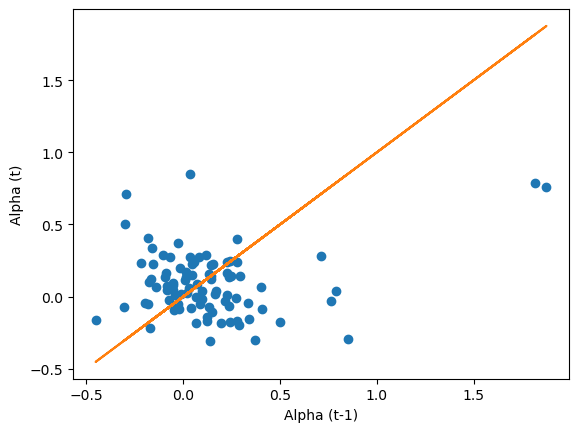

In [265]:
plt.plot(results_df.groupby('Ticker').shift(1)['Alpha'],results_df.Alpha , 'o')
plt.plot(results_df['Alpha'],results_df.Alpha , '-')
plt.xlabel('Alpha (t-1)')
plt.ylabel('Alpha (t)')

Text(0, 0.5, 'Alpha (t)')

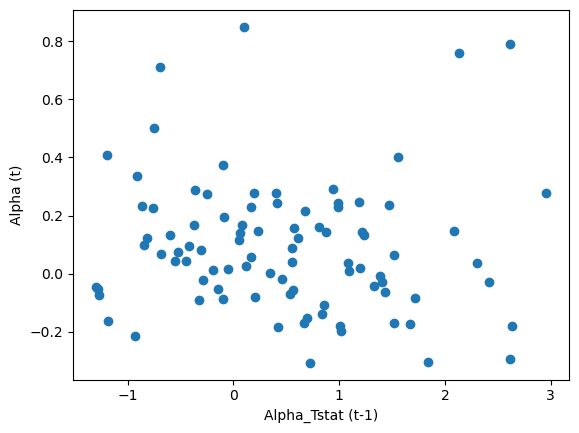

In [268]:
plt.plot(results_df.groupby('Ticker').shift(1)['Alpha_Tstat'],results_df.Alpha , 'o')

plt.xlabel('Alpha_Tstat (t-1)')
plt.ylabel('Alpha (t)')

- You see that no matter the horizon there is no PREDICTIVE relationship, last period alpha is not related to future period alpha
- You see that even if you sort on t-stat, it is not better
- Even quite high T-stats are not associated with higher future alphas 
- This is not surprising!
- Alpha is all you want and all you need. So everyone is chasing it

 

- So you expect that alpha of an asset or a trading strategy should be very transient-- it will quickly disappears as people learn about it
- This will pose a challenge for you


## How do you find alpha?

- Estimating Alpha is hard!
- Every one in the business in searching for alpha
- So true alpha is
  - hard to find
  - disappears quickly
  - if the data was clear, people would already jumped at it
  - Once too much capital is in the trade we say that the trade is "crowded"
  - A Crowded trade can yield NEGATIVE alpha, even if the original idea was right!
  - You have to be right, but also early. 
  - If the trade gets crowded after you already in, is that good or bad? What do you do?
 

## If not estimation then what?

You need to think!


- Valuation. You understand a business/market and think the market is not seeing what you are seeing. IT can be short-term insight, like a big client will cancel their services, or long-term prospects for the company business. 
  - Warren Buffet whole stick is about this. Read his letters to shareholders. It is all about finding good firms at good value
  - David Einhorn is another example. He famously betted against Leahman Brothers. 
  - Often this view will be formed by not only looking at balance sheets , but interacting with company insiders. Even though interactions are public, access allow a good fundamental analyst to see things more clearly (if you get private information, it is of course "easier" but it is illegal and you might end up in jail!)
  - Edge here is having good business judgment. You need to be confident that you are seeing something different form the market and you are right!
  - IT is good discipline to think why people are thinking the wrong thing--you need to understand why the opportunity is there in the first place
  
- Liquidity provision 
  - When firms are downgraded some fund are forced to sell, this often creates reversals
  - Similar effect happens when a firm is dropped from an index, say SP500
  - And it happens in the opposite direction when it is added to the index
  - When mutual fund suffers outflows, they often have to sell, this often creates reversals are as well
  - The bet here is that you understand the reason these buy and sells are happening--and that they are not about fundamental news
  - So you bet the price movements triggered by them will ultimate revert, so you take the other side of the trade--i.e. provide liquidity (at a sweet premium of course)
  
- Data that other people don't have.
  - Famous example are satellite pictures of parking lots of retail stores--might allow you to predict sales better which hopefully translates into predictions about prices once the market becomes aware of the sales
  - Flow data--this is slightly different from liquidity provision--as you can front run buys/sells if you know that the flows are coming and that they will move markets
  - flooding data, exposure to temperature, 
  - supplier data
  - See below a diagram by JP Morgan illustrating the variety of data sources


![Alternative Data](../../assets/plots/alternativedata.png)



## Alpha Quantification Procedure

- Regardless how you get to you alpha, in the end you have to put your trading insights in the same playing field
- Need to choose an horizon, say a month, and put all your alpha in that frequency.

Example:

- Say you have a theory that NVDIA currently trading at 1000 will be at 800 in one year due to things that entirely specific to NVDIA (that is a -20% return)
- Suppose you do not have a theory of when exactly that will happen 
- Then you alpha for next month is $(0.8)^{(1/12)}-1\approx-1.8\%$
- Now suppose you know the timing--so you know this  bad news is likely to come only on the last two earnings of the year, then you alpha=0 for the first six months of the year and $(0.8)^{(1/6)}-1\approx-3.6\%$ for last six months of the year



## Alpha is unique and cannot be driven by broad macro factors

- It is useful to develop views for a range of firms/ industries to check that you are not implicitly making a market-wide bet
- if that is your bet, it is silly to hedge market risk--and it is stupid to buy a single stock to trade this view
- You should just buy the market in this case!
- And it is important to be aware because it is much hard to be right!
- In practice the notion of "broad macro factors" is much broader then market beta and will often include exposure to a variety of factors, including industry factors
- While it is ok to make a bet on an industry, it is important to know exactly what your trade is
- Buying NVDIA because your bullish on the tech sector is stupid--you should buy the whole tech sector in that case--much less risk per unit of exposure- as it is not exposed to NVDIA specific factors?
  


> #### Extra Material: The Normal distribution

* Most of what we do does not depend on the assumption of normality

* But normal distributions are very useful in statistical tests

* And they are also not a bad approximation for return data at low frequency (monthly/year) 

* Probability that any random draw form a Normal distribution random variable $\tilde{x}$ is within $n=1$ standard deviation from the mean is 0.6826


$$Prob(E[\tilde{x}]-1\sigma(\tilde{x})\leq \tilde{x}\leq E[\tilde{x}]+1\sigma(\tilde{x}))=0.6826$$

* $n=2,Prob(\cdot)=0.9550$

$$Prob(E[\tilde{x}]-2\sigma(\tilde{x})\leq \tilde{x}\leq E[\tilde{x}]+2\sigma(\tilde{x}))=0.9550$$
* it is convenient to to transform a normally distributed r.v. into units of standard deviations from it's mean


$$\tilde{z}=\frac{\tilde{x}-E[\tilde{x}]}{\sigma(\tilde{x})}$$

* This follows the "standard" normal distribution, which has mean 0 and and standard deviation 1 

* can you show that is indeed the case that z has mean zero and standard devaiton 1? 

* This means that the normal distribution is completely characterized by it's first two moments

* This means that the investment problem is much more tractable too!

* Only two moments to worry about:

    * The expected return of the portfolio
    
    * it's variance
    
    * The probability of really bad tail events will follow immediately from these two! 

In [271]:
from scipy.stats import norm

#quantile function
x=norm.ppf(0.95)
print(norm.ppf(0.95))
# cdf
norm.cdf(x)

1.6448536269514722


0.95